In [1]:
import pickle
import random
from typing import List

from gensim.corpora import Dictionary
import numpy as np

In [2]:
with open(r"data/interim/model_3/positive_words.pkl", "rb") as input_file:
    positive_docs = pickle.load(input_file)

In [3]:
with open(r"data/interim/model_3/negative_words.pkl", "rb") as input_file:
    negative_docs = pickle.load(input_file)

In [4]:
# First negative review
negative_docs[0]

['go',
 'hotel',
 'directly',
 'book',
 'room',
 'receptionist',
 'first',
 'really',
 'high',
 'price',
 'lower',
 'ask',
 'much',
 'cost',
 'qetale',
 'gave_us',
 'comission',
 'rate',
 'dollar',
 'know',
 'randomly',
 'gove',
 'exist',
 'rate',
 'lower',
 'real',
 'rate',
 'agree',
 'price',
 'include',
 'breakfast',
 'follow',
 'morning',
 'get',
 'breakfast',
 'receive',
 'plain',
 'piece',
 'toast',
 'fruit',
 'theoth',
 'table',
 'receive',
 'also',
 'egg',
 'plantine',
 'ask',
 'also',
 'get',
 'egg',
 'plantine',
 'reply',
 'come',
 'get',
 'breakfast',
 'pay',
 'good',
 'experience',
 'hotel',
 'place',
 'stay']

In [5]:
import math
import random

def split_data(data, weights = [0.8, 0.2]):
    number_data = len(data)
    split_limit = math.floor((number_data * weights[0]))
    
    data_train = data[:split_limit]
    data_test = data[split_limit:]
    
    return data_train, data_test

In [6]:
# We shuffle the lists before splitting the data
# We establish a seed to ensure reproducibility
random.seed(123)

# Shuffle reviews
positive_docs = random.sample(positive_docs, len(positive_docs) )
negative_docs = random.sample(negative_docs, len(negative_docs))

negative_train, negative_test = split_data(negative_docs)
positive_train, positive_test = split_data(positive_docs)

print(negative_train[0])

['quaint', 'look', 'hotel', 'pretty', 'courtyard', 'roof', 'door', 'room', 'metal', 'glass', 'sound', 'deaden', 'ability', 'people', 'slam', 'night', 'place', 'real', 'noise', 'problem', 'luckily', 'ear_plug', 'friend', 'stay', 'close', 'front', 'complain', 'music', 'night', 'fight', 'couple', 'could_hear', 'every_word', 'bed_linen', 'look', 'bit', 'mattress', 'firm', 'ok', 'shower', 'cold_water', 'little', 'electric', 'heater', 'attach', 'spout', 'mine', 'horrible', 'hard', 'turn', 'water', 'cold', 'water', 'little', 'heater', 'keep', 'leak', 'little', 'skylight', 'bathroom', 'leak', 'mucky', 'water', 'typical', 'part', 'world']


In [7]:
positive_words = [item for sublist in positive_train for item in sublist]
negative_words = [item for sublist in negative_train for item in sublist]

In [8]:
def create_dictionary(documents: List[List[str]]):
    return Dictionary(documents)

In [9]:
dictionary = create_dictionary([negative_words, positive_words])

In [10]:
# for entry in dictionary.items():
#     print(entry)

In [11]:
def split_data(data: List, weights: List = (1, 0, 0)):
    split = {
        'train': [],
        'test': [],
        'validation': [],
    }
    for word in data:
        subset = random.choices(['train', 'test', 'validation'], weights=weights)[0]
        split[subset].append(word)

    return split

In [12]:
positive_docs_split = split_data(positive_docs)
negative_docs_split = split_data(negative_docs)

In [13]:
negative_words_split = {key: [item for sublist in value for item in sublist] for key, value in negative_docs_split.items()}
positive_words_split = {key: [item for sublist in value for item in sublist] for key, value in positive_docs_split.items()}

In [14]:
print(len(negative_words_split['train']))
print(len(negative_words_split['validation']))
print(len(negative_words_split['test']))

37178
0
0


In [15]:
negative_bow = dictionary.doc2bow(negative_words_split['train'])
positive_bow = dictionary.doc2bow(positive_words_split['train'])

total_negative_words = len(negative_words_split['train']) + len(dictionary)
total_positive_words = len(positive_words_split['train']) + len(dictionary)

In [16]:
print(total_negative_words)
print(total_positive_words)

52390
520772


In [17]:
negative_word_probs = {}
for id, count in negative_bow:
    negative_word_probs[dictionary[id]] = {
        'id': id,
        'logprob': np.log((count + 1)/total_negative_words),
    }

negative_word_probs[-1] = {
    'id': -1,
    'logprob': np.log(1/total_negative_words)
}

In [18]:
positive_word_probs = {}
for id, count in positive_bow:
    positive_word_probs[dictionary[id]] = {
        'id': id,
        'logprob': np.log((count + 1)/total_positive_words),
    }
positive_word_probs[-1] = {
    'id': -1,
    'logprob': np.log(1/total_positive_words)
}

In [19]:
negative_prob = len(negative_docs_split["train"]) / (len(negative_docs_split["train"]) + len(positive_docs_split["train"]))
positive_prob = len(positive_docs_split["train"]) / (len(negative_docs_split["train"]) + len(positive_docs_split["train"]))

In [20]:
negative_prob

0.05637036092335161

In [21]:
positive_prob

0.9436296390766484

In [22]:
model = {
    'POS_PROB': np.log(positive_prob),
    'NEG_PROB': np.log(negative_prob),
    'COND_POS_PROBS': positive_word_probs,
    'COND_NEG_PROBS': negative_word_probs
}

In [23]:
import pprint 

pp = pprint.PrettyPrinter(indent=1, depth= 1)
pp.pprint(model)

{'COND_NEG_PROBS': {...},
 'COND_POS_PROBS': {...},
 'NEG_PROB': -2.875811774153224,
 'POS_PROB': -0.058021521305370964}


In [24]:
def perf_measure(y_actual, y_predicted): 
    tp = np.sum((y_actual == 1) & (y_predicted == 1))
    tn = np.sum((y_actual == 0) & (y_predicted == 0))
    fp = np.sum((y_predicted == 1) & (y_actual != y_predicted))
    fn = np.sum((y_predicted == 0) & (y_actual != y_predicted))

    #  Precision
    if (tp + fp) > 0:
        precision = tp / (tp + fp)
    else:
        precision = -1
    
    # Recall
    if (tp + fn) > 0:
        recall = tp / (tp + fn)
    else:
        recall = -1
   
    # Acc 
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    
    # F1
    if precision >= 0 and recall >= 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = -1
    
    return (precision, recall, accuracy, f1, tp, tn, fp, fn)

In [25]:
def predict(model, reviews):
    y_predicted = []

    for review in reviews:
        positive_count = 0
        negative_count = 0
        for word in review:
            if model.get("COND_POS_PROBS").get(word) is not None:
                positive_count += model.get("COND_POS_PROBS").get(word).get('logprob')
            if model.get("COND_NEG_PROBS").get(word) is not None:
                negative_count += model.get("COND_NEG_PROBS").get(word).get('logprob')
                
        positive_count += model.get("POS_PROB")
        negative_count += model.get("NEG_PROB")
        
        if positive_count >= negative_count:
            y_predicted.append(0)
        else:
            y_predicted.append(1)

    return(y_predicted)
            

In [26]:
import numpy as np

y_predicted_positive = predict(model, positive_test)
y_predicted_negative = predict(model, negative_test)

y_positive = np.ones(len(y_predicted_positive))
y_negative = np.zeros(len(y_predicted_negative))

y_predicted = np.array(y_predicted_positive + y_predicted_negative)
y_actual = np.concatenate([y_positive, y_negative])

precision, recall, accuracy, _, _, _, _, _ = perf_measure(y_actual, y_predicted)

print("precision: ", round(precision, 2))
print("recall:", round(recall, 2))
print("accuracy: ", round(accuracy, 2))


precision:  0.94
recall: 0.66
accuracy:  0.64


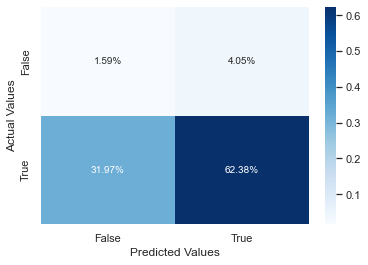

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import confusion_matrix

sns.set_theme()


cf_matrix = confusion_matrix(y_actual, y_predicted)
ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt=".2%", cmap='Blues')

ax.xaxis.set_ticklabels(["False","True"])
ax.yaxis.set_ticklabels(["False","True"])

ax.set_xlabel("Predicted Values")
ax.set_ylabel("Actual Values")

plt.show()


In [28]:
with open(r"models/model_3.pkl", "wb") as output_file:
    pickle.dump(model, output_file)

"The staff was super friendly, the food was superb ..."

review -----> tokenize

`["staff", "be", "friendly", "food" "be", "superb"]`

$\log P(\text{staff}|+) + \log P(\text{be}|+) + \log P(\text{friendly}|+)+ \log P(\text{food}|+) + \log P(\text{food}|+) + \log P(\text{superb}|+)+ \log P(+) = -203.42$
$\log P(\text{staff}|-) + \log P(\text{be}|-) + \log P(\text{friendly}|-)+ \log P(\text{food}|-) + \log P(\text{food}|-) + \log P(\text{superb}|-)+ \log P(-) = -400.47$